[View in Colaboratory](https://colab.research.google.com/github/Manelmc/rnn-time-to-event/blob/master/Turbofan%20Engine/predictive-maintenance-turbofan-engine.ipynb)

# Predictive Maintenance for the Turbofan Engine Dataset


## Data Preparation

In [1]:
import keras
import keras.backend as K

print "Keras version", keras.__version__

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Setting seed for reproducibility
SEED = 42
np.random.seed(SEED)  

/anaconda2/envs/ALL_BF/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras version 2.2.0


In [2]:
!mkdir Dataset
!mkdir Models

!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O Dataset/PM_test.txt 
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O Dataset/PM_train.txt  
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O Dataset/PM_truth.txt
  
!ls Dataset

PM_test.txt  PM_train.txt  PM_truth.txt


### Turbofan Train Set

In [2]:
from sklearn import preprocessing

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df[train_df["id"] == 1].tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
187,1,188,0.114943,0.750000,0.0,0.0,0.765060,0.683235,0.684166,0.0,...,0.091599,0.753367,0.0,0.666667,0.0,0.0,0.286822,0.089202,4,0.518006
188,1,189,0.465517,0.666667,0.0,0.0,0.894578,0.547853,0.772451,0.0,...,0.090670,0.744132,0.0,0.583333,0.0,0.0,0.263566,0.301712,3,0.520776
189,1,190,0.344828,0.583333,0.0,0.0,0.731928,0.614345,0.737677,0.0,...,0.065229,0.759523,0.0,0.833333,0.0,0.0,0.271318,0.239299,2,0.523546
190,1,191,0.500000,0.166667,0.0,0.0,0.641566,0.682799,0.734639,0.0,...,0.075704,0.740669,0.0,0.500000,0.0,0.0,0.240310,0.324910,1,0.526316
191,1,192,0.551724,0.500000,0.0,0.0,0.701807,0.662089,0.758778,0.0,...,0.056714,0.717199,0.0,0.666667,0.0,0.0,0.263566,0.097625,0,0.529086


### Turbofan Test Set

In [3]:
from sklearn import preprocessing

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df[test_df["id"] == 1].tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
26,1,27,0.459770,0.583333,0.0,0.0,0.262048,0.340310,0.304862,0.0,...,0.140881,0.479030,0.0,0.333333,0.0,0.0,0.565891,0.688898,0.072022,116
27,1,28,0.626437,0.916667,0.0,0.0,0.216867,0.505995,0.321404,0.0,...,0.180359,0.469796,0.0,0.333333,0.0,0.0,0.534884,0.629660,0.074792,115
28,1,29,0.580460,0.583333,0.0,0.0,0.222892,0.351210,0.267725,0.0,...,0.171277,0.370527,0.0,0.333333,0.0,0.0,0.682171,0.646092,0.077562,114
29,1,30,0.356322,0.833333,0.0,0.0,0.475904,0.320035,0.316003,0.0,...,0.179843,0.331281,0.0,0.250000,0.0,0.0,0.736434,0.707954,0.080332,113
30,1,31,0.465517,0.833333,0.0,0.0,0.412651,0.221932,0.281229,0.0,...,0.155692,0.298192,0.0,0.416667,0.0,0.0,0.519380,0.636564,0.083102,112


### Apply right padding to all the sequences

In [ ]:
def pad_sequence(df, max_seq_length, mask=0):
    """
    Applies right padding to a sequences until max_seq_length with mask 
    """
    return np.pad(df.values, ((0, max_seq_length - df.values.shape[0]), (0,0)), 
                  "constant", constant_values=mask)
  
def pad_engines(df, cols, max_batch_len, mask=0):
    """
    Applies right padding to the columns "cols" of all the engines 
    """
    return np.array([pad_sequence(df[df['id'] == batch_id][cols], max_batch_len, mask=mask) 
                     for batch_id in df['id'].unique()])
  
max_batch_len = train_df['id'].value_counts().max()
train_cols = ['s' + str(i) for i in range(1,22)] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
test_cols = ["RUL"]

X = pad_engines(train_df, train_cols, max_batch_len)
Y = pad_engines(train_df, test_cols, max_batch_len)

### Split into train, validation and test

In [4]:
from sklearn.model_selection import train_test_split

# Split into train and validation
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.20, random_state=SEED)

# Test set from CMAPSS
test_X = pad_engines(test_df, train_cols, max_batch_len)
test_Y = pad_engines(test_df, test_cols, max_batch_len)

# In the WTTE-RNN architecture we will predict 2 parameters (alpha and beta)
# alpha is initialised to 1
train_Y_wtte = np.concatenate((train_Y, np.ones(train_Y.shape)), axis=2)
val_Y_wtte = np.concatenate((val_Y, np.ones(val_Y.shape)), axis=2)
test_Y_wtte = np.concatenate((test_Y, np.ones(test_Y.shape)), axis=2)

print "Train:\n", "  X:", train_X.shape, "\n  Y:", train_Y.shape, "\n  Y_wtte:", train_Y_wtte.shape
print "\nValidation:\n", "  X:", val_X.shape, "\n  Y:", val_Y.shape, "\n  Y_wtte:", val_Y_wtte.shape
print "\nTest:\n", "  X:", test_X.shape, "\n  Y:", test_Y.shape, "\n  Y_wtte:", test_Y_wtte.shape

Train:
  X: (80, 362, 25) 
  Y: (80, 362, 1) 
  Y_wtte: (80, 362, 2)

Validation:
  X: (20, 362, 25) 
  Y: (20, 362, 1) 
  Y_wtte: (20, 362, 2)

Test:
  X: (100, 362, 25) 
  Y: (100, 362, 1) 
  Y_wtte: (100, 362, 2)


## Baseline

In [6]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=0)
# dimensions of the model
nb_features = train_X.shape[2]
nb_out = train_Y.shape[2]
# Model path
baseline_path = "baseline_model"

model = Sequential()
# Masking layer so the right padding is ignored 
# at each layer of the network 
model.add(Masking(mask_value=0., 
                  input_shape=(max_batch_len, nb_features)))
# Then there s an LSTM layer with 100 units 
# Recurrent Dropout is also applied after each 
# LSTM layer to control overfitting. 
model.add(LSTM(
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
# followed by another LSTM layer with 50 units
model.add(LSTM(
         units=50,
         recurrent_dropout=0.2,
         return_sequences=True))
# Final layer is a Time-Distributed Dense layer
# with a single unit with an Exponential activation
model.add(TimeDistributed(Dense(nb_out, activation=K.exp)))
model.compile(loss="mse", optimizer=keras.optimizers.RMSprop())

print(model.summary())

# fit the network
history = model.fit(train_X, train_Y, epochs=500, batch_size=16, 
                    validation_data=(val_X, val_Y), shuffle=True, 
                    verbose=2, callbacks = [early_stopping, checkpoint])

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 362, 25)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 362, 100)          50400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 362, 50)           30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 362, 1)            51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
Train on 80 samples, validate on 20 samples
Epoch 1/500
 - 16s - loss: 15456.0848 - val_loss: 6900.5324
Epoch 2/500
 - 14s - loss: 6877.5924 - val_loss: 5549.6422
Epoch 3/500
 - 14s - loss: 6091.0797 - val_loss: 5398.0746
Epoch 4/500
 - 14s - loss: 5915.1381 - val_

In [0]:
# Execute if training in Colaboratory (preferably from Chrome)
# Downloads the model after the training finishes

from google.colab import files
files.download(baseline_path)

# Move the model to the expected folder
!mv baseline_path Models/

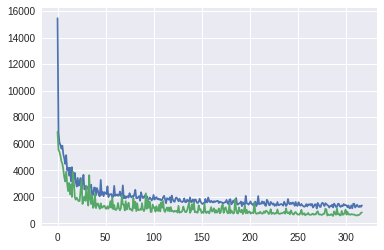

In [11]:
# Validation loss vs the Training loss

%matplotlib inline

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [1]:
# Execute if you want to upload a model to Collaboratory

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [66]:
from keras.models import load_model

# It's important to load the model after the training
# The keras Checkpoint will save the best model in terms
# of the validation loss in the specified path
model = load_model("Models/" + baseline_path, custom_objects={"exp": K.exp})

,0,1,2
Method,MAE,RMSE,R2
Train,21.19,33.57,0.766
Validation,17.36,23.98,0.866
Test,27.03,37.41,0.598


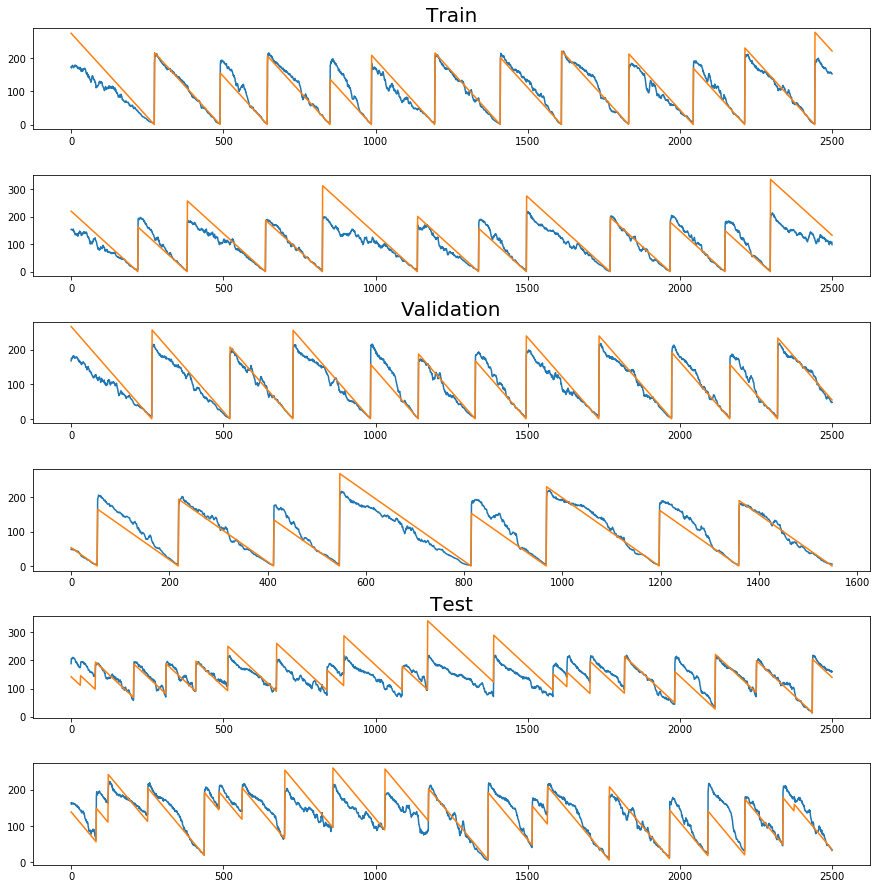

In [67]:
%matplotlib inline
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# We save the validation errors to later compare the models
validation_baseline = model.predict(val_X).flatten()

def evaluate_and_plot(model, evaluation_data, weibull_function=None):
    """
    Generate scores dataframe and plot the RUL
    """
    fig = plt.figure()
    i = 1
    score_df = pd.DataFrame({"Method": ["MAE", "RMSE", "R2"]})
    for name_set, train_set, test_set in evaluation_data:
        if weibull_function is None:
            y_pred = model.predict(train_set).flatten()
        else:
            y_pred = [weibull_function(alpha, beta) 
                      for batch in model.predict(train_set) 
                      for beta, alpha in batch]
        l = test_set[:,:,0].flatten()
        # To validate we remove the right padding
        y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
        y_pred = np.ma.compressed(np.ma.masked_where(l==0, y_pred))
        score_mae = "{0:.2f}".format(mean_absolute_error(y_true, y_pred))
        score_rmse = "{0:.2f}".format(sqrt(mean_squared_error(y_true, y_pred)))
        score_r2 = "{0:.3f}".format(r2_score(y_true, y_pred))
        score_df[name_set] = [score_mae, score_rmse, score_r2]
        ax = fig.add_subplot(6, 1, i)
        ax.title.set_text(name_set)
        ax.title.set_fontsize(20)
        i += 1
        plt.plot(y_pred[0:2500])
        plt.plot(y_true[0:2500])
        ax = fig.add_subplot(6, 1, i)
        i += 1
        plt.plot(y_pred[2500:5000])
        plt.plot(y_true[2500:5000])
    plt.subplots_adjust(hspace=0.45)
    fig.set_size_inches(15, i*2.2)
    return score_df.T

evaluate_and_plot(model,
                  [("Train", train_X, train_Y), 
                   ("Validation", val_X, val_Y), 
                   ("Test", test_X, test_Y)])

## Adapting to WTTE-RNN

In [9]:
# Install wtte package from Martinsson

!pip install wtte

  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0


In [0]:
# Loss and activation functions from Martinsson
# These are not used in the final version because 
# the wtte package has useful regularization tools

def weibull_loglik_discrete(y_true, y_pred, epsilon=K.epsilon()):
    y = y_true[..., 0]
    u = y_true[..., 1]
    a = y_pred[..., 0]
    b = y_pred[..., 1]
    
    hazard0 = K.pow((y + epsilon) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)

    loss = u * K.log(K.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return -loss

def activation_weibull(y_true):
    a = y_true[..., 0]
    b = y_true[..., 1]
    
    a = K.exp(a)
    b = K.sigmoid(b)
    return K.stack([a, b], axis=-1)

In [68]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Lambda
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
import wtte.weibull as weibull
import wtte.wtte as wtte

# Since we use a lambda in the last layer the model 
# is not saved well in keras, instead we save the weights.
# This requires compiling the model to load the weights
baseline_wtte_path = "baseline_wtte_model_weights"
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_wtte_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=0)

nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

model = Sequential()

model.add(Masking(mask_value=0.,
                  input_shape=(max_batch_len, nb_features)))
model.add(LSTM(
         input_shape=(None, nb_features),
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(LSTM(
          units=50,
          recurrent_dropout=0.2,
          return_sequences=True))
model.add(TimeDistributed(Dense(2)))
# uncomment this line and comment the next to use 
# activation_weibull function:
# model.add(Activation(activation_weibull))
model.add(Lambda(wtte.output_lambda, 
                 arguments={# Initialization value around it's scale
                            "init_alpha": np.nanmean(train_Y_wtte[:,0]), 
                            # Set a maximum
                            "max_beta_value": 10.0
                           },
                ))
# Same for the loss "weibull_loglik_discrete"
# model.compile(loss=weibull_loglik_discrete, optimizer='rmsprop')
# We use clipping on the loss
loss = wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function

model.compile(loss=loss, optimizer='rmsprop')

In [19]:
print(model.summary())

# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=500, batch_size=16, 
                    validation_data=(val_X, val_Y_wtte), shuffle=True, verbose=2,
                    callbacks = [early_stopping, checkpoint, TerminateOnNaN()])

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, None, 25)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 100)         50400     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2)           102       
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 2)           0         
Total params: 80,702
Trainable params: 80,702
Non-trainable params: 0
_________________________________________________________________
None
Train on 80 samples, validate on 20 samples
Epoch 1/500
 - 15s - loss: 4.3735 - val_loss: 3.7142
Epoch 2/500
 - 13s - loss: 3.8081 - 

In [0]:
# Execute if training in Colaboratory (preferably from Chrome)
# Downloads the model after the training finishes

from google.colab import files
files.download(baseline_wtte_path)

# Move the model to the expected folder
!mv baseline_wtte_path Models/

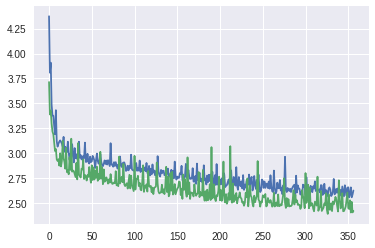

In [28]:
%matplotlib inline


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [35]:
# Execute if you want to upload a model to Collaboratory

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving baseline_wtte_model_weights (1) to baseline_wtte_model_weights (1)
User uploaded file "baseline_wtte_model_weights (1)" with length 340528 bytes


In [70]:
# Compile model first to load weights

model.load_weights("Models/" + baseline_wtte_path)

### Weibull Methods

$\mu = \beta\Gamma(1 + \alpha^{-1})$

$\sigma^2 = \beta^2[\Gamma(1 + 2\alpha^{-1}) - \Gamma^2(1 + \alpha^{-1})]$

$mode = \beta\frac{\alpha-1}{\alpha}^{1/\alpha}$

Inverse CDF $ = \beta (-\log(1 - x))^\frac{1}{\alpha} $ when $ 0<x<1 $

In [74]:
from math import gamma, log, sqrt

def mean_weibull(alpha, beta):
    return beta*gamma(1 + 1./alpha)

def mode_weibull(alpha, beta):
    return beta*((alpha-1)/alpha)**(1./alpha) if alpha > 1 else 0

def median_weibull(alpha, beta):
    return beta*(log(2)**(1./alpha))

def var_weibull(alpha, beta):
    return beta**2*(gamma(1 + 2./alpha) - gamma(1 + 1./alpha)**2)

def pdf_weibull(x, alpha, beta):
    return (alpha/beta)*(x/beta)**(alpha - 1)*np.exp(-(x/beta)**alpha)

def inverse_cdf_weibull(x, alpha, beta):
    return beta*np.power((-np.log(1.-x)), 1./alpha)

### Mean, Mode and Median



![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Visualisation_mode_median_mean.svg/150px-Visualisation_mode_median_mean.svg.png)

Mode
                0      1      2
Method        MAE   RMSE     R2
Train       21.53  34.69  0.750
Validation  17.94  26.48  0.836
Test        27.46  38.59  0.572

Median
                0      1      2
Method        MAE   RMSE     R2
Train       21.05  33.51  0.767
Validation  17.79  25.48  0.848
Test        26.72  37.49  0.596

Mean
                0      1      2
Method        MAE   RMSE     R2
Train       20.94  33.14  0.772
Validation  17.79  25.26  0.851
Test        26.51  37.22  0.602


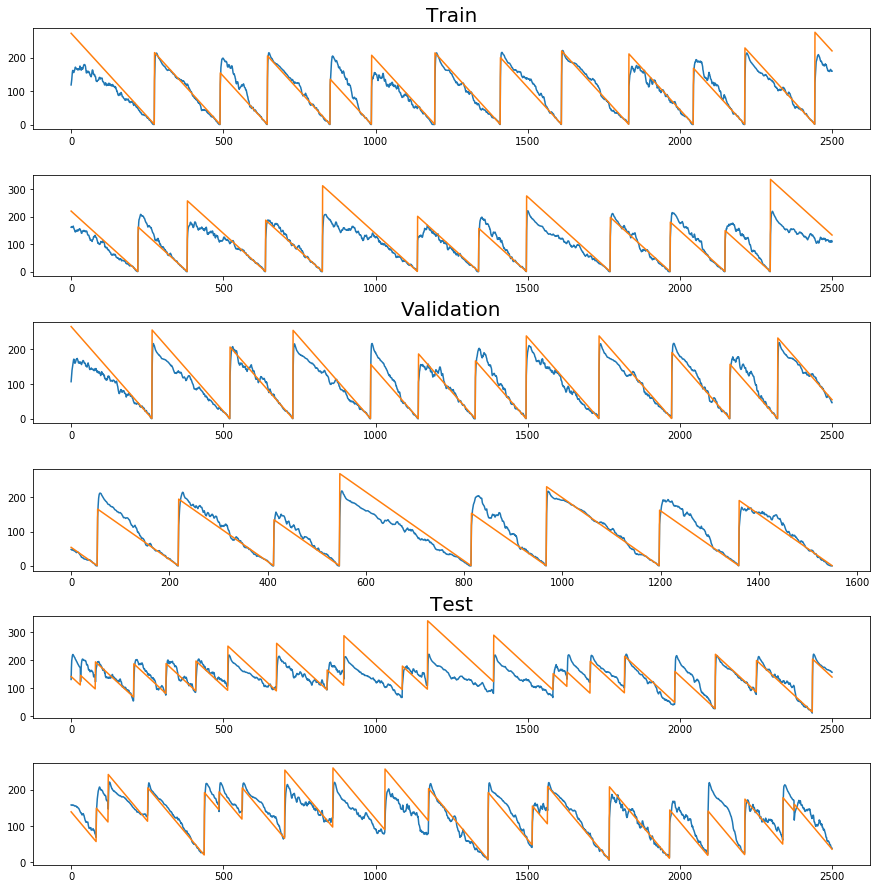

In [76]:
%matplotlib inline

print "Mode"
print evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = mode_weibull)

# comment the next line to visualise the plot for the mode
plt.close()

print "\nMedian"
print evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = median_weibull)

# comment the next line to visualise the plot for the median
plt.close()

print "\nMean"
print evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = mean_weibull)

### Evolution of the pdf through the cycles of an engine (PLOT)

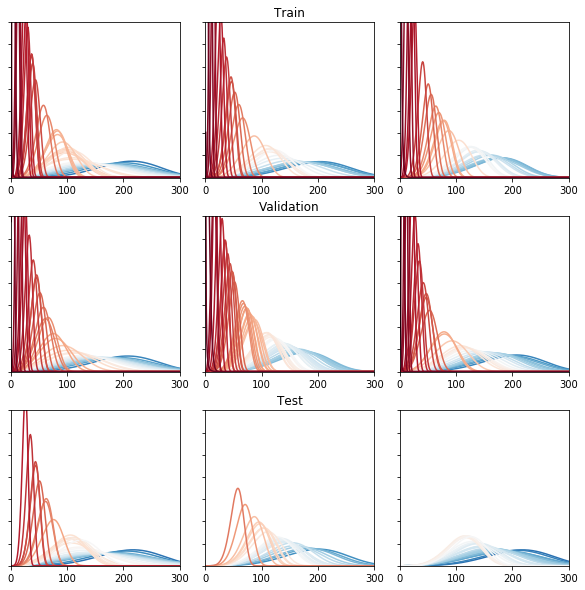

In [77]:
import random

import seaborn as sns


random.seed(SEED)
lot = random.sample(train_X, 3) 
random.seed(SEED)
lot += random.sample(val_X, 3)
random.seed(SEED)
lot += random.sample(test_X, 3)

palette = list(reversed(sns.color_palette("RdBu_r", 250)))

fig = plt.figure()
j = 1
for batch in lot:
    size = batch[~np.all(batch == 0, axis=1)].shape[0]
    y_pred_wtte = model.predict(batch.reshape(1, max_batch_len, nb_features))[0]
    y_pred_wtte = y_pred_wtte[:size]
    x = np.arange(1, 400.)
    
    freq = 5
    ax = fig.add_subplot(3, 3, j)
    
    i=0
    for beta, alpha in y_pred_wtte[0::freq][2:]:
        mean = mode_weibull(alpha, beta)
        color=palette[int(mean)] if i < len(palette) else palette[-1]
        plt.plot(x, pdf_weibull(x, alpha, beta), color=color)
        i += 1
    ax.set_ylim([0, 0.07])
    ax.set_xlim([0, 300])
    ax.set_yticklabels([])
    if j == 2:
        ax.title.set_text("Train")
    elif j == 5:
        ax.title.set_text("Validation")
    elif j == 8:
        ax.title.set_text("Test")
    j += 1

plt.subplots_adjust(wspace=0.15, hspace=0.25)
fig.set_size_inches(10,10)

### Evolution of the pdf through the cycles of an engine (GIFs)

In [19]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy.stats import dweibull

from math import gamma


def var_weibull(alpha, beta):
    return beta**2*(gamma(1 + 2./alpha) - gamma(1 + 1./alpha)**2)
    
def survival_weibull(x, alpha, beta):
    #return np.e**-((x/beta)**alpha)
    return 1 - dweibull(beta, 0, alpha).cdf(x)

def generate_gif(y_pred, y_true, path, freq=2):
    # remove mask if exists 
    y_true = y_true[y_true != 0]
    y_pred = y_pred[:y_true.shape[0]]

    frames = zip(y_true, y_pred)

    # pad, w_pad, h_pad, and rect
    fig = plt.figure()
    global ax1, ax2
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    fig.set_tight_layout(True)
    x = np.arange(1, 300.)
    beta, alpha = y_pred[0]
    line1, = ax1.plot(x, pdf_weibull(x, alpha, beta))
    global i, acc_y_true, acc_y_pred
    i = 0
    predict_mean = mean_weibull(alpha, beta)
    ax2.plot(i, y_true[0], 'bo', label="True", ms=2.5)
    ax2.plot(i, predict_mean, 'o', color="orange", label="Predicted", ms=2.5)
    ax2.legend(loc="upper right")
    # limits
    ax1.set_ylim([0, 0.07])
    ax2.set_ylim([0, y_true[0] + 10])
    ax2.set_xlim([0, len(frames)/freq + 2])
    ax2.set_xticklabels([])
    # acc values
    acc_y_true = []
    acc_y_pred = []
    
    def update(instant):
        y_true_t, y_pred_t = instant
        beta, alpha = y_pred_t
        # print y_true
        pdf = pdf_weibull(x, alpha, beta)
        line1.set_ydata(pdf)
        global i, acc_y_true, acc_y_pred
        i += 1
        mean = mean_weibull(alpha, beta)
        surv = survival_weibull(mean, alpha, beta)
        sigma = np.sqrt(var_weibull(alpha, beta))
        acc_y_pred += [mean]
        acc_y_true += [y_true_t]
        ax2.plot(range(len(acc_y_true)), acc_y_true, 'b', label="True")
        # facecolor='blue', alpha=0.5
        ax2.plot(range(len(acc_y_pred)), acc_y_pred, color="orange", label="Predicted")
        conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
        ax1.set_title("PDF Weibull Distrib. (Mean: " + "{0:.1f}".format(mean)
                     + ", Std: " + "{0:.1f}".format(sigma) + ")"
                     + " S(t): " + str(surv))
                     #+ " Conf. 95%: [{0:.1f}, {1:.1f}]".format(*conf))
        ax2.set_title("Real RUL: " + str(y_true_t) + " cycles")

    fig.set_size_inches(15,4)
    anim = FuncAnimation(fig, update, frames=frames[0::freq])
    anim.save(path, writer="imagemagick")
    plt.close()

eng_id = 1 
lot = train_Y[eng_id]
y_pred_wtte = model.predict(train_X[eng_id].reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/engine1.gif"
generate_gif(y_pred_wtte, lot, gif_path, freq=4)

from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')

/anaconda2/envs/ALL_BF/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:1115: RuntimeWarning: overflow encountered in power
  Cx1 = 0.5 * np.exp(-abs(x)**c)


### Confidence Interval of the Weibull Distribution

/anaconda2/envs/ALL_BF/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


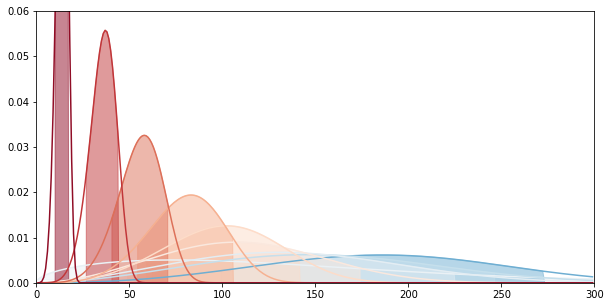

In [84]:
%matplotlib inline

from scipy.stats import dweibull

batch = lot[0]
size = batch[~np.all(batch == 0, axis=1)].shape[0]
y_pred_wtte = model.predict(batch.reshape(1, max_batch_len, nb_features))[0]
y_pred_wtte = y_pred_wtte[:size]

fig = plt.figure()
fig.add_subplot(1,1,1)
for beta, alpha in y_pred_wtte[0::20]:
    x = np.arange(1, 300.)
    mean = mean_weibull(alpha, beta)
    sigma = np.sqrt(var_weibull(alpha, beta))
    plt.plot(x, pdf_weibull(x, alpha, beta), color=palette[int(mean)])
    # alpha is the shape parameter
    conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
    plt.fill([conf[0]] + list(np.arange(conf[0], conf[1])) + [conf[1]], 
             [0] + list(pdf_weibull(np.arange(conf[0], conf[1]), alpha, beta)) + [0], 
             color=palette[int(mean)], alpha=0.5)

axes = plt.gca()
axes.set_ylim([0., 0.06])
axes.set_xlim([0., 300.])
fig.set_size_inches(10,5)

## GRU variant

In [86]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, GRU, TimeDistributed, Lambda
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
import wtte.weibull as weibull
import wtte.wtte as wtte

baseline_gru_path = "baseline_gru_model_weights"

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_gru_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=0)

nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

init_alpha = np.nanmean(train_Y_wtte[:,0])

model = Sequential()
model.add(Masking(mask_value=0.,
                  input_shape=(max_batch_len, nb_features)))
# We substitute LSTM for GRU
model.add(GRU(
         input_shape=(None, nb_features),
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(GRU(
          units=50,
          recurrent_dropout=0.2,
          return_sequences=True))
model.add(TimeDistributed(Dense(2)))
model.add(Lambda(wtte.output_lambda, 
                 arguments={# Initialization value around it's scale
                            "init_alpha": np.nanmean(train_Y_wtte[:,0]), 
                            # Set a maximum
                            "max_beta_value": 10.0,
                            # We set the scalefactor to avoid exploding gradients
                            "scalefactor": 0.25
                           },
                ))
loss = wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function
model.compile(loss=loss, optimizer='rmsprop')

In [27]:
print(model.summary())

# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=500, batch_size=16, 
                    validation_data=(val_X, val_Y_wtte), shuffle=True, verbose=2,
                    callbacks = [early_stopping, checkpoint, TerminateOnNaN()])

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, None, 25)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, None, 100)         37800     
_________________________________________________________________
gru_7 (GRU)                  (None, None, 50)          22650     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2)           102       
_________________________________________________________________
lambda_5 (Lambda)            (None, None, 2)           0         
Total params: 60,552
Trainable params: 60,552
Non-trainable params: 0
_________________________________________________________________
None
Train on 80 samples, validate on 20 samples
Epoch 1/500
 - 6s - loss: 5.1202 - val_loss: 4.7694
Epoch 2/500
 - 4s - loss: 4.2887 - va

Epoch 136/500
 - 4s - loss: 2.8985 - val_loss: 2.7297
Epoch 137/500
 - 4s - loss: 2.9523 - val_loss: 2.7498
Epoch 138/500
 - 4s - loss: 2.9294 - val_loss: 2.7452
Epoch 139/500
 - 4s - loss: 2.9528 - val_loss: 2.7777
Epoch 140/500
 - 4s - loss: 2.9418 - val_loss: 2.7602
Epoch 141/500
 - 4s - loss: 2.9651 - val_loss: 2.7372
Epoch 142/500
 - 4s - loss: 2.9010 - val_loss: 2.7786
Epoch 143/500
 - 4s - loss: 2.9388 - val_loss: 2.7708
Epoch 144/500
 - 4s - loss: 3.0072 - val_loss: 2.8947
Epoch 145/500
 - 4s - loss: 2.9218 - val_loss: 2.8294
Epoch 146/500
 - 4s - loss: 2.8972 - val_loss: 2.7352
Epoch 147/500
 - 4s - loss: 2.9768 - val_loss: 2.7259
Epoch 148/500
 - 4s - loss: 2.9459 - val_loss: 2.7276
Epoch 149/500
 - 4s - loss: 2.8694 - val_loss: 2.7362
Epoch 150/500
 - 4s - loss: 2.9803 - val_loss: 2.7256
Epoch 151/500
 - 4s - loss: 2.9233 - val_loss: 2.7233
Epoch 152/500
 - 4s - loss: 2.8820 - val_loss: 2.7857
Epoch 153/500
 - 4s - loss: 2.8853 - val_loss: 2.8489
Epoch 154/500
 - 4s - loss: 

Epoch 288/500
 - 4s - loss: 2.6890 - val_loss: 2.4710
Epoch 289/500
 - 4s - loss: 2.6307 - val_loss: 2.5116
Epoch 290/500
 - 4s - loss: 2.5466 - val_loss: 2.4415
Epoch 291/500
 - 4s - loss: 2.6254 - val_loss: 2.4783
Epoch 292/500
 - 4s - loss: 2.5705 - val_loss: 2.4830
Epoch 293/500
 - 4s - loss: 2.5340 - val_loss: 2.5436
Epoch 294/500
 - 4s - loss: 2.5538 - val_loss: 2.5730
Epoch 295/500
 - 4s - loss: 2.5717 - val_loss: 2.7305
Epoch 296/500
 - 4s - loss: 2.5576 - val_loss: 2.4139
Epoch 297/500
 - 4s - loss: 2.6201 - val_loss: 2.4043
Epoch 298/500
 - 4s - loss: 2.5680 - val_loss: 2.6545
Epoch 299/500
 - 4s - loss: 2.5237 - val_loss: 2.4790
Epoch 300/500
 - 4s - loss: 2.6359 - val_loss: 2.4010
Epoch 301/500
 - 4s - loss: 2.5529 - val_loss: 2.4126
Epoch 302/500
 - 5s - loss: 2.6243 - val_loss: 2.4576
Epoch 303/500
 - 5s - loss: 2.5449 - val_loss: 2.4173
Epoch 304/500
 - 4s - loss: 2.5318 - val_loss: 2.4095
Epoch 305/500
 - 4s - loss: 2.4766 - val_loss: 2.4216
Epoch 306/500
 - 4s - loss: 

In [ ]:
# Execute if training in Colaboratory (preferably from Chrome)
# Downloads the model after the training finishes

from google.colab import files
files.download(baseline_gru_path)

# Move the model to the expected folder
!mv baseline_gru_path Models/

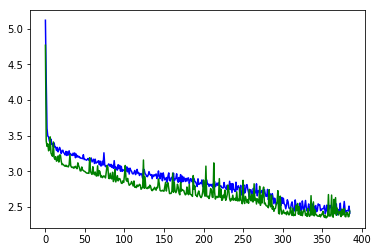

In [31]:
%matplotlib inline

plt.plot(history.history["loss"], color="blue")
plt.plot(history.history["val_loss"], color="green")

In [ ]:
# Execute if you want to upload a model to Collaboratory

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [87]:
# Compile model first to load weights

model.load_weights("Models/" + baseline_gru_path)

,0,1,2
Method,MAE,RMSE,R2
Train,15.94,25.90,0.861
Validation,18.30,27.46,0.824
Test,25.82,36.70,0.613


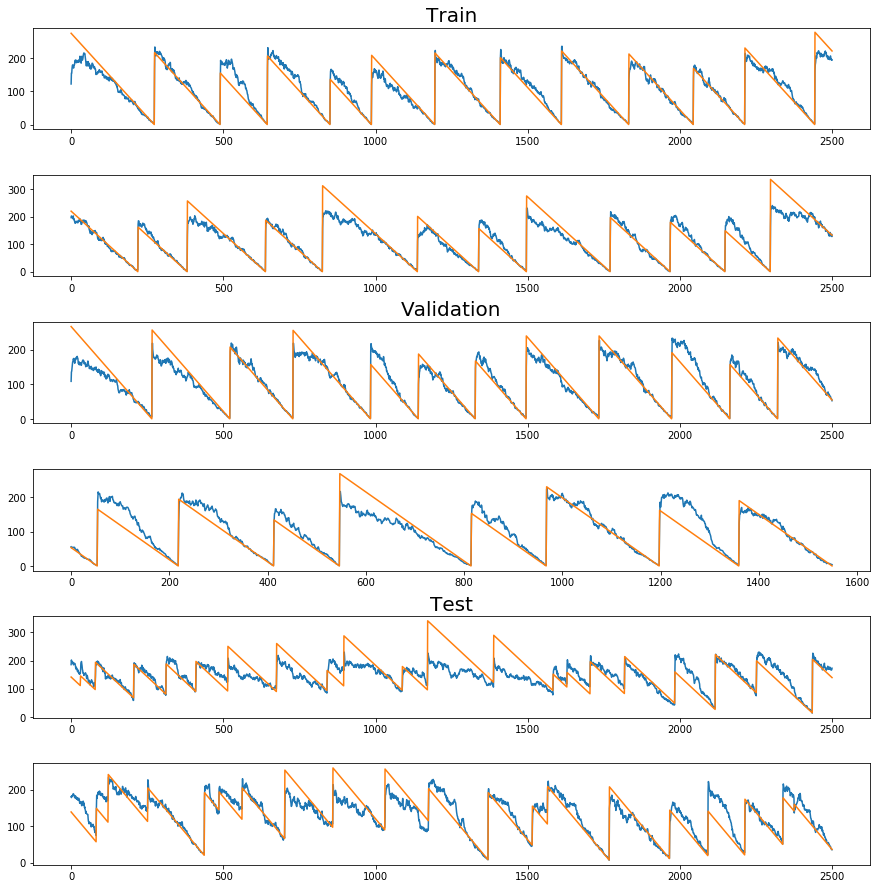

In [88]:
evaluate_and_plot(model,
                  [("Train", train_X, train_Y_wtte), 
                   ("Validation", val_X, val_Y_wtte), 
                   ("Test", test_X, test_Y_wtte)],
                  weibull_function = mean_weibull)